正在安裝必要的函式庫...
成功偵測到 GPU: Tesla T4
開始執行流程...

--- 正在生成衛星地形圖 (DreamShaper 8) ---


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

CLIPFeatureExtractor appears to have been deprecated in transformers. Using CLIPImageProcessor instead.


正在生成中 (DreamShaper 8)...


  0%|          | 0/40 [00:00<?, ?it/s]


--- 正在轉換為高度圖 (Depth Anything V2) ---


Device set to use cuda:0



--- 生成結果預覽 ---


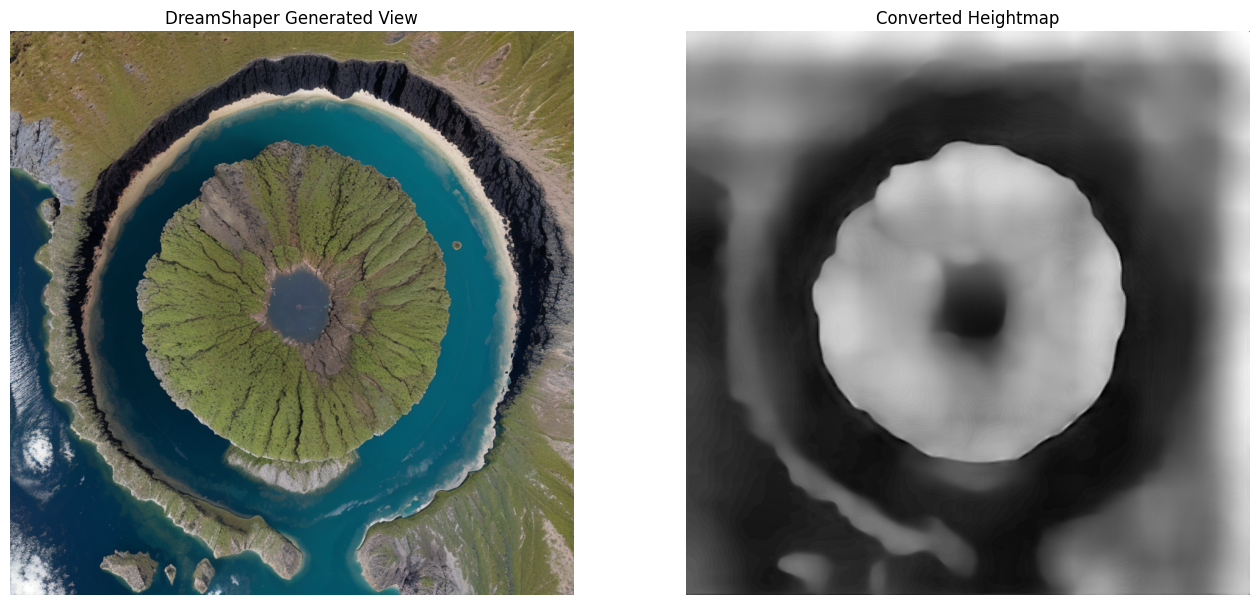


正在下載 heightmap.png ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

import os

print("正在安裝必要的函式庫...")
!pip install -q diffusers transformers accelerate safetensors opencv-python

import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from transformers import pipeline
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("警告: 未偵測到 GPU！")
else:
    print(f"成功偵測到 GPU: {torch.cuda.get_device_name(0)}")

OUTPUT_SATELLITE = "satellite_view.png"
OUTPUT_HEIGHTMAP = "heightmap.png"

def generate_satellite_image():
    print("\n--- 正在生成衛星地形圖 (DreamShaper 8) ---")

    # 使用 DreamShaper 8 (基於 SD 1.5 的頂級微調模型)
    model_id = "Lykon/dreamshaper-8"

    # SD 1.5 架構不需要 VAE fix，原生支援 float16，非常穩定
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        variant="fp16",
    )

    # 使用 DPM++ 2M SDE Karras，這是 DreamShaper 推薦的採樣器，細節最好
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(
        pipe.scheduler.config,
        use_karras_sigmas=True,
        algorithm_type="dpmsolver++"
    )
    pipe.enable_model_cpu_offload()

    # --- Prompt (螺旋島) ---
    # 針對 DreamShaper 風格微調了提示詞
    prompt = (
        "Aerial top-down satellite view of a massive volcanic island. "
        "A perfect circular caldera lake in the center. "
        "High steep rocky mountain rim surrounding the lake. "
        "Danger zone, dark rock texture, tropical vegetation on the outer slopes. "
        "8k resolution, highly detailed texture, national geographic style."
    )

    negative_prompt = (
        "clouds, fog, mist, smoke, text, watermark, label, "
        "bridge, man-made, buildings, roads, boat, ship, "
        "lowres, bad anatomy, bad hands, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, username, blurry"
    )

    print("正在生成中 (DreamShaper 8)...")

    # DreamShaper 擅長 512~768 解析度，我們用 768x768 兼顧細節與穩定
    image = pipe(
        prompt,
        negative_prompt=negative_prompt,
        width=768,
        height=768,
        num_inference_steps=40, # DreamShaper 30 步就很完美
        guidance_scale=7.0
    ).images[0]

    del pipe
    torch.cuda.empty_cache()

    image.save(OUTPUT_SATELLITE)
    return image

def generate_depth_map(image):
    print("\n--- 正在轉換為高度圖 (Depth Anything V2) ---")

    depth_estimator = pipeline(
        task="depth-estimation",
        model="LiheYoung/depth-anything-small-hf",
        device=0 if device == "cuda" else -1
    )

    result = depth_estimator(image)
    depth_image = result["depth"]
    del depth_estimator
    torch.cuda.empty_cache()

    # 後處理
    depth_array = np.array(depth_image)
    depth_min = depth_array.min()
    depth_max = depth_array.max()

    if depth_max - depth_min > 0:
        depth_normalized = (depth_array - depth_min) / (depth_max - depth_min) * 255.0
    else:
        depth_normalized = depth_array

    depth_normalized = depth_normalized.astype(np.uint8)

    # 增強對比，讓螺旋紋路更深
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
    enhanced_depth = clahe.apply(depth_normalized)

    final_heightmap = Image.fromarray(enhanced_depth)
    final_heightmap.save(OUTPUT_HEIGHTMAP)

    return final_heightmap

# === 主程式 ===
print("開始執行流程...")
satellite_img = generate_satellite_image()
heightmap_img = generate_depth_map(satellite_img)

print("\n--- 生成結果預覽 ---")
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(satellite_img)
ax[0].set_title("DreamShaper Generated View")
ax[0].axis('off')
ax[1].imshow(heightmap_img, cmap='gray')
ax[1].set_title("Converted Heightmap")
ax[1].axis('off')
plt.show()

print(f"\n正在下載 {OUTPUT_HEIGHTMAP} ...")
try:
    files.download(OUTPUT_HEIGHTMAP)
except Exception as e:
    print(f"自動下載失敗: {e}")